This tutorial demonstrates how to generate images of handwritten digits using a Deep Convolutional Generative Adversarial Network (DCGAN). The code is written using the Keras Sequential API with a tf.GradientTape training loop.

What are GANs?
Generative Adversarial Networks (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A generator ("the artist") learns to create images that look real, while a discriminator ("the art critic") learns to tell real images apart from fakes.



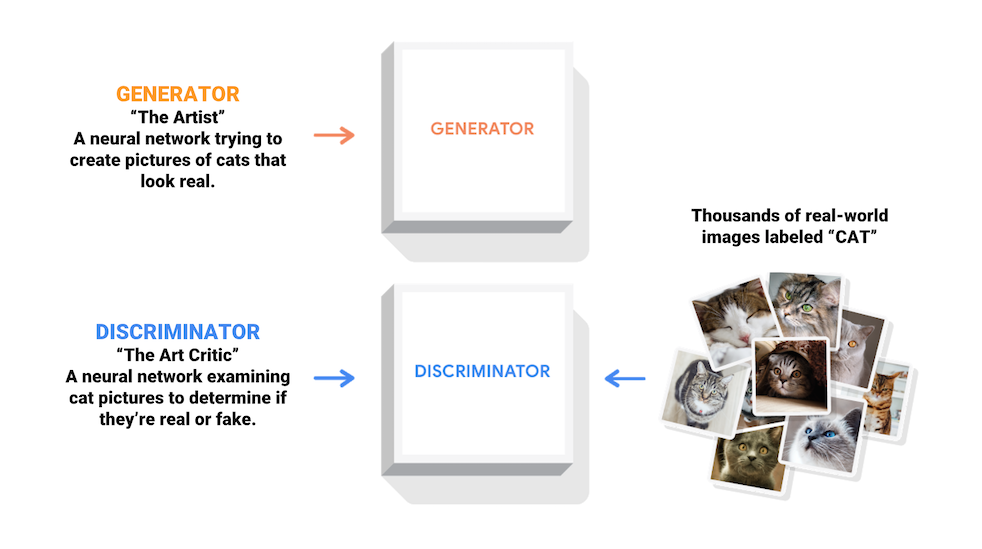

During training, the generator progressively becomes better at creating images that look real, while the discriminator becomes better at telling them apart. The process reaches equilibrium when the discriminator can no longer distinguish real images from fakes

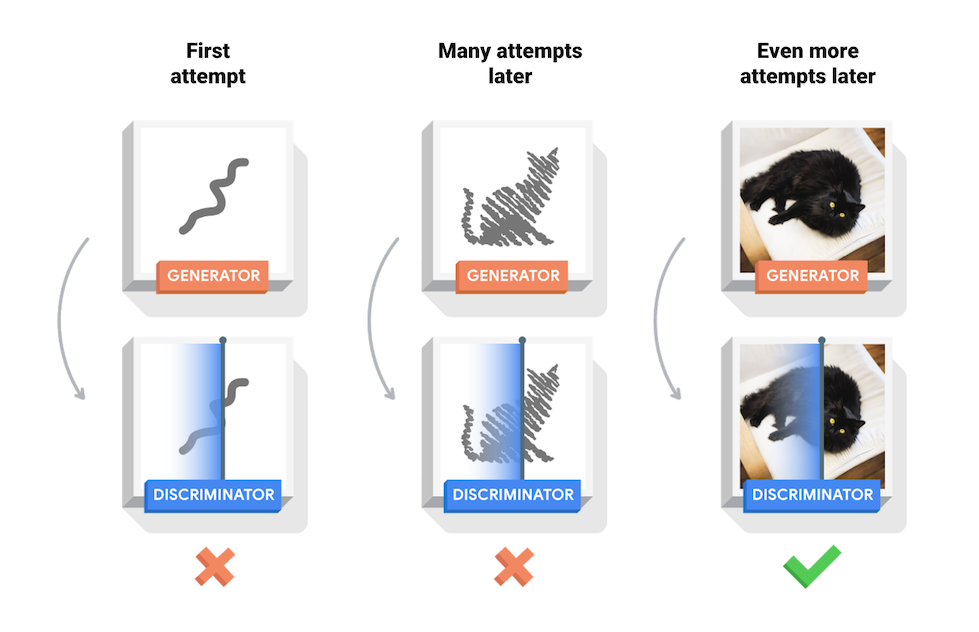

This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the generator as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

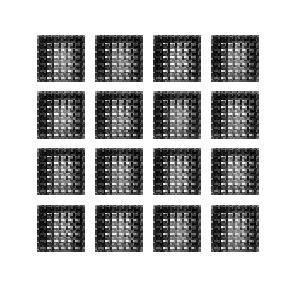

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.18.0'

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

Load and prepare the dataset
You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [7]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
train_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

Create the models
Both the generator and discriminator are defined using the Keras Sequential API.

The Generator
The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the tf.keras.layers.LeakyReLU activation for each layer, except the output layer which uses tanh.

In [48]:
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-1.1326036 , -0.19218491, -1.3508136 ,  0.5067751 ,  1.3486643 ,
         0.96106356, -0.10808612,  0.36972082, -0.69735944, -0.6335364 ,
        -0.48947302, -0.68594855,  0.24431512,  1.499193  ,  0.7565978 ,
        -1.4304565 , -0.5717922 ,  0.3718141 , -1.3667002 , -1.4176512 ,
         0.00368221, -0.10603549, -0.3235058 , -0.17522211, -2.5184379 ,
         1.0617565 , -1.197422  , -0.0467329 ,  1.7557149 , -2.7185793 ,
         0.44224644, -0.4215421 , -0.72161615, -0.84271526, -1.7955687 ,
        -0.51451397, -0.7722909 ,  0.8612955 ,  0.4514112 , -0.0313049 ,
        -1.2517352 ,  0.01650035,  1.6520973 ,  2.071456  ,  0.29918677,
        -0.16647731,  1.026668  , -1.2788454 ,  0.29188603,  0.8235666 ,
        -0.62673306, -2.5529652 ,  1.8517275 ,  0.69862574, -0.45035508,
        -1.7717928 ,  0.09880314, -0.55049247,  1.2675205 ,  0.97022575,
         1.5420219 , -0.5326355 , -2.4395614 , -0.39979026,  1.6359437 ,
 

The Discriminator
The discriminator is a CNN-based image classifier.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

# Build generator
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Build discriminator
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])
    return model

# Initialize generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

# Generate noise and an image
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

# Evaluate the generated image
decision = discriminator(generated_image)
print("Discriminator's decision:", decision.numpy())


Discriminator's decision: [[0.5002378]]


In [49]:
generator.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_41 (LeakyReLU)      │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_9 (Reshape)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_27             │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_42 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_28             │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_43 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_29             │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [50]:
discriminator.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_44 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_45 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-1.1326036 , -0.19218491, -1.3508136 ,  0.5067751 ,  1.3486643 ,
         0.96106356, -0.10808612,  0.36972082, -0.69735944, -0.6335364 ,
        -0.48947302, -0.68594855,  0.24431512,  1.499193  ,  0.7565978 ,
        -1.4304565 , -0.5717922 ,  0.3718141 , -1.3667002 , -1.4176512 ,
         0.00368221, -0.10603549, -0.3235058 , -0.17522211, -2.5184379 ,
         1.0617565 , -1.197422  , -0.0467329 ,  1.7557149 , -2.7185793 ,
         0.44224644, -0.4215421 , -0.72161615, -0.84271526, -1.7955687 ,
        -0.51451397, -0.7722909 ,  0.8612955 ,  0.4514112 , -0.0313049 ,
        -1.2517352 ,  0.01650035,  1.6520973 ,  2.071456  ,  0.29918677,
        -0.16647731,  1.026668  , -1.2788454 ,  0.29188603,  0.8235666 ,
        -0.62673306, -2.5529652 ,  1.8517275 ,  0.69862574, -0.45035508,
        -1.7717928 ,  0.09880314, -0.55049247,  1.2675205 ,  0.97022575,
         1.5420219 , -0.5326355 , -2.4395614 , -0.39979026,  1.6359437 ,
 

In [52]:
generated_image

<tf.Tensor: shape=(1, 28, 28, 1), dtype=float32, numpy=
array([[[[ 7.90997234e-04],
         [-3.85962543e-04],
         [-1.78221101e-03],
         [-4.81714634e-03],
         [ 3.19135282e-03],
         [-2.76430044e-03],
         [ 2.72342283e-03],
         [-6.87740231e-03],
         [-2.94745737e-03],
         [-1.08044164e-03],
         [ 6.47727284e-04],
         [-3.37965228e-03],
         [ 2.17643101e-03],
         [-5.35769854e-03],
         [ 8.92916881e-03],
         [-1.28128994e-02],
         [ 4.34196973e-03],
         [-2.47638370e-03],
         [ 8.54161382e-03],
         [-1.02835968e-02],
         [-8.50462820e-03],
         [-1.59163717e-02],
         [ 3.50131956e-03],
         [-2.57893559e-03],
         [-5.86024253e-03],
         [ 5.34298038e-03],
         [-3.99215333e-03],
         [-5.21434285e-03]],

        [[ 1.41495169e-04],
         [ 8.19819327e-03],
         [-4.79234150e-03],
         [-9.22626071e-03],
         [-1.92670859e-02],
         [ 1.51208

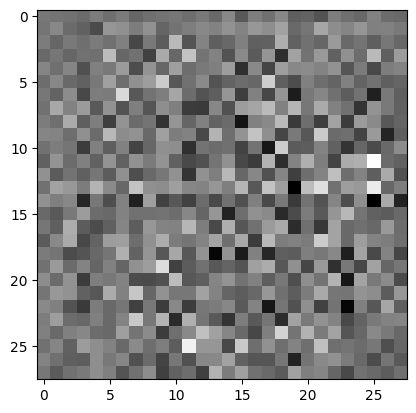

In [53]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Define the loss and optimizers
Define loss functions and optimizers for both models

In [54]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Discriminator loss
This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [56]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return real_loss, fake_loss, total_loss

Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [57]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [58]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [59]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Define the training loop

In [60]:
EPOCHS = 5
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

generates a random tensor of values sampled from a normal (Gaussian) distribution. This is commonly used in Generative Adversarial Networks (GANs) as the input to the generator model. Here's a detailed breakdown:

In [61]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [63]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

tf.random.normal
This TensorFlow function generates random numbers from a normal distribution.
A normal distribution is a bell-shaped curve with the following properties:
Mean (average): Default is 
0
0.
Standard deviation (spread): Default is 
1
1.
[BATCH_SIZE, noise_dim]
The shape of the tensor to generate:
BATCH_SIZE: The number of samples in a batch. Each sample corresponds to one input for the generator.
noise_dim: The dimensionality of the random noise vector. Each sample is a vector of size noise_dim

In [62]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

Train the model
Call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

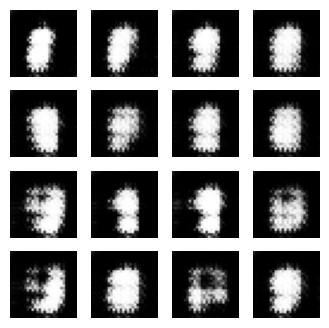

Time for epoch 2 is 211.04197359085083 sec


KeyboardInterrupt: 

In [64]:
train(train_dataset, EPOCHS)

In [65]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


Create a GIF

In [66]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [67]:
display_image(EPOCHS)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\a27_YEARS_OLD\\deep_learning\\CV\\image_at_epoch_0005.png'

Use imageio to create an animated gif using the images saved during training

In [68]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_6444\1982054950.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_6444\1982054950.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
